In [1]:
from pandas_datareader import data
from datetime import datetime
from datetime import date
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('coffee_weekly.csv')
df.head

<bound method NDFrame.head of             Date        Open        High         Low       Close   Adj Close  \
0     2000-01-03  124.000000  124.000000  113.800003  114.150002  114.150002   
1     2000-01-10  126.000000  126.000000  112.250000  112.550003  112.550003   
2     2000-01-17  112.000000  118.800003  110.599998  111.199997  111.199997   
3     2000-01-24  111.000000  116.400002  110.949997  114.699997  114.699997   
4     2000-01-31  114.000000  114.500000  109.800003  112.900002  112.900002   
...          ...         ...         ...         ...         ...         ...   
1238  2023-09-25  150.300003  152.149994  144.949997  146.149994  146.149994   
1239  2023-10-02  146.000000  151.399994  144.449997  146.050003  146.050003   
1240  2023-10-09  146.050003  155.649994  143.699997  154.899994  154.899994   
1241  2023-10-16  154.899994  166.800003  152.100006  165.250000  165.250000   
1242  2023-10-20  163.399994  166.800003  162.250000  165.649994  165.649994   

      Vol

In [3]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000
mean,128.793846,133.018302,124.987289,128.768986,128.768986,44575.376508
std,50.435122,52.142386,48.836379,50.437704,50.437704,44817.056740
min,42.500000,43.250000,41.500000,42.599998,42.599998,4.000000
25%,99.699997,102.900002,97.000000,99.625000,99.625000,594.000000
50%,121.550003,125.250000,118.400002,121.449997,121.449997,36482.000000
75%,151.324997,156.775002,147.000000,151.300003,151.300003,71355.500000
max,298.350006,306.250000,284.500000,299.350006,299.350006,234010.000000


In [4]:
df.reset_index(inplace=True,drop =False)
df.drop(['Open','High','Low', 'Adj Close'], axis =1, inplace =True)
# Convert 'Date' column to ordinal format
df['Date'] = df['Date'].apply(lambda x: datetime.toordinal(pd.Timestamp(x)))

# Convert DataFrame to a list of tuples
data_tuples = list(df.itertuples(index=False, name=None))

In [5]:
dates = np.array(df['Date'])
end_val = np.array(df['Close'])
volume = np.array(df['Volume'])[1:] 

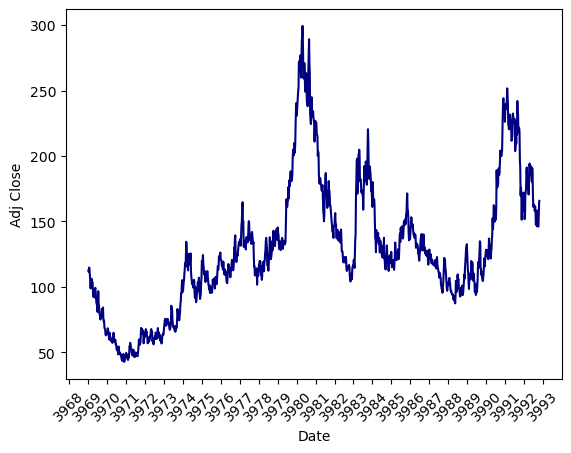

In [6]:
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator

diff = np.diff(end_val)
dates = dates[1:]
end_val = end_val[1:]
X = np.column_stack([diff,volume])

fig, ax = plt.subplots()
plt.gca().xaxis.set_major_locator(YearLocator())
plt.plot_date(dates,end_val, "-", color = "navy")
plt.xticks(rotation = 45)
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.show()

In [7]:
from hmmlearn import hmm

model = hmm.GaussianHMM(n_components=5, covariance_type="diag", n_iter=1000)
model.fit(X)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


GaussianHMM(n_components=5, n_iter=1000)

In [8]:
hidden_states = model.predict(X)
pd.DataFrame(hidden_states, columns = ["hidden_state"])

,hidden_state
0,0
1,0
2,0
3,0
4,0
...,...
1237,2
1238,2
1239,2
1240,2


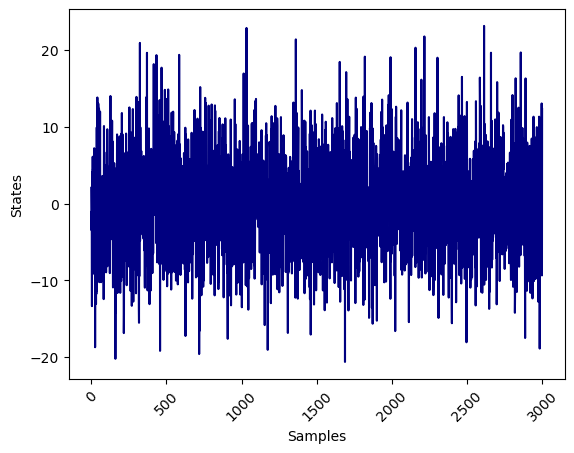

In [9]:
num_sample = 3000
sample, _ = model.sample(num_sample)
plt.plot(np.arange(num_sample), sample[:,0],color ="navy")
plt.xlabel("Samples")
plt.ylabel("States")
plt.xticks(rotation= 45)
plt.show()

In [10]:
for i in range(model.n_components):
    print("{0} order hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()

0 order hidden state
mean =  [1.91995993e-01 2.79710454e+04]
var =  [1.13967858e+01 1.55611814e+08]

1 order hidden state
mean =  [ -0.27534559 219.26836263]
var =  [3.32093669e+01 4.55606882e+04]

2 order hidden state
mean =  [2.44003546e-01 1.13411391e+05]
var =  [4.04797280e+01 1.28022381e+09]

3 order hidden state
mean =  [7.76275593e-01 1.85013723e+04]
var =  [4.66362929e+01 3.21525658e+08]

4 order hidden state
mean =  [-1.97840532e-01  6.22945799e+04]
var =  [4.47130851e+01 2.74680386e+08]



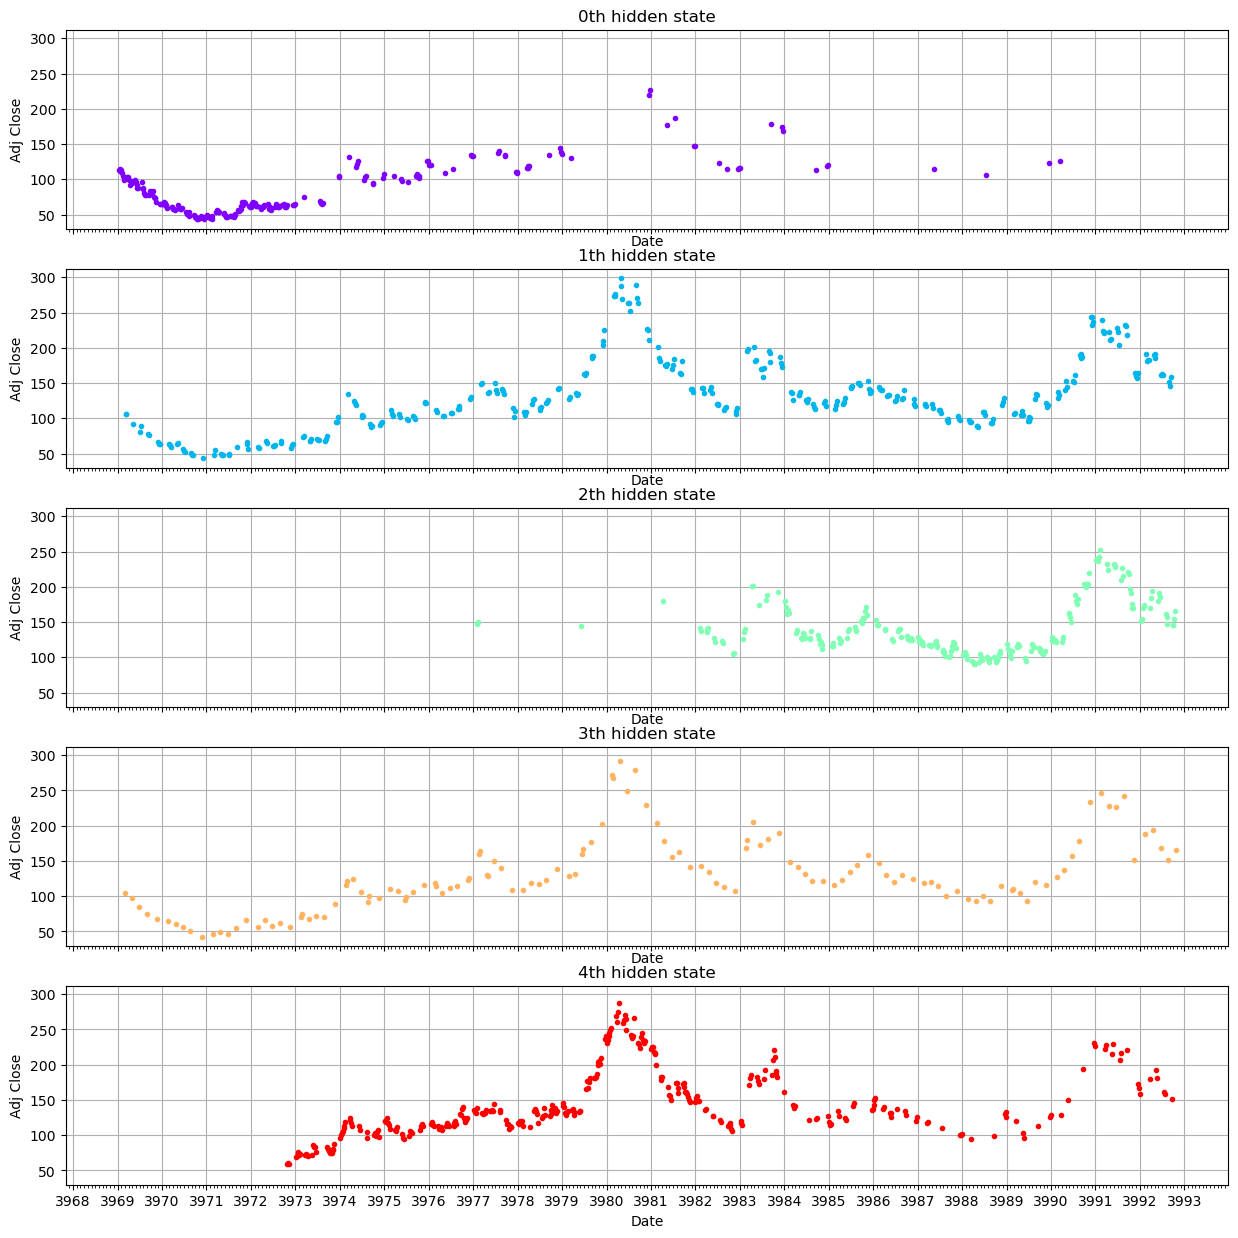

In [11]:
from  matplotlib import cm
from  matplotlib.dates import MonthLocator 
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True,
figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    mask = hidden_states == i
    ax.plot_date(dates[mask], end_val[mask], ".", c=colour)
    ax.set_title("{0}th hidden state".format(i))
    ax.set_xlabel("Date")
    ax.set_ylabel("Adj Close")
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    ax.grid(True)
plt.show()


In [12]:
expected_returns_and_volumes = np.dot(model.transmat_, model.means_)
returns_and_volume_comumnwise = list(zip(*expected_returns_and_volumes))
expected_returns = returns_and_volume_comumnwise[0]
expected_volumes = returns_and_volume_comumnwise[1]
params = pd.concat([pd.Series(expected_returns), pd.Series(expected_volumes)], axis = 1)
params.columns = ['Returns', 'Volume']
pd.DataFrame(params) 

,Returns,Volume
0,0.168783,34506.250345
1,-0.171045,17246.289872
2,0.390166,87348.994825
3,-0.117156,2969.350697
4,-0.008442,66242.735802


In [17]:
date.today() 

datetime.date(2023, 10, 22)

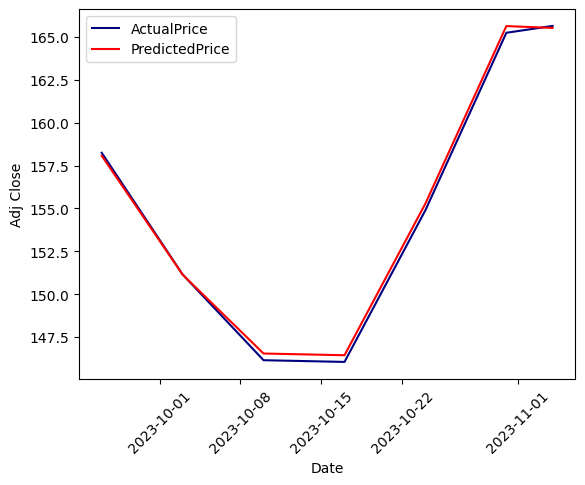

In [25]:
from datetime import timedelta


lastN = 7
start_date = date.today() - timedelta(days = lastN*2)
dates = df['Date']
predicted_prices = []
predicted_dates = []
predicted_volumes = []
actual_volumes = []

for idx in range(lastN):
    state = hidden_states[-lastN+idx]
    current_price = df.iloc[-lastN+idx ]['Close']
    volume = df.iloc[-lastN+idx]['Volume']
    actual_volumes.append(volume)
    current_date = date.fromordinal(dates.iloc[-lastN+idx])
    predicted_date = current_date + timedelta(days=1)
    predicted_dates.append(predicted_date)
    predicted_prices.append(current_price + expected_returns[state])
    predicted_volumes.append(np.round(expected_volumes[state]))
fig, ax = plt.subplots()
plt.plot(predicted_dates,end_val[-lastN:],color="navy",label="ActualPrice")
plt.plot(predicted_dates,predicted_prices,color="red",label="PredictedPrice")
plt.legend(loc="best")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.show()



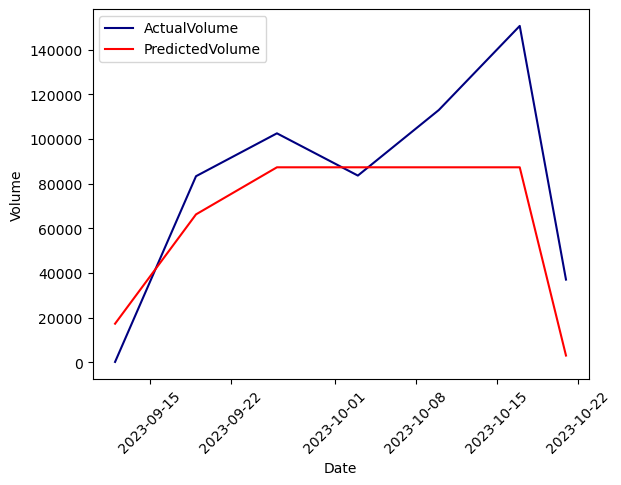

In [16]:
fig, ax = plt.subplots()
plt.plot(predicted_dates,actual_volumes,color="navy",label="ActualVolume")
plt.plot(predicted_dates,predicted_volumes,color="red",label="PredictedVolume")
plt.legend(loc="best")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()